<a href="https://colab.research.google.com/github/bourama1/SMAP/blob/main/SMAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SMAP Project

## Installation and import

In [1]:
%pip install -q tfds-nightly tensorflow matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 18.2 MB/s eta 0:00:00


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

## Load and visualize the dataset

In [ ]:
# Load the dataset
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'places365_small',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Filter classes
train_ds = train_ds.filter(lambda img, label, filename: label == 0 or label == 4 or label == 5 or label == 10 or label == 19 or label == 27 or label == 30 or label == 39 or label == 48 or label == 62 or label == 66 or label == 77 or label == 81 or label == 84 or label == 85 or label == 86 or label == 91 or label == 97 or label == 116 or label == 125 or label == 150 or label == 171 or label == 180 or label == 182 or label == 190 or label == 204 or label == 205 or label == 214 or label == 220)
val_ds = train_ds.filter(lambda img, label, filename: label == 0 or label == 4 or label == 5 or label == 10 or label == 19 or label == 27 or label == 30 or label == 39 or label == 48 or label == 62 or label == 66 or label == 77 or label == 81 or label == 84 or label == 85 or label == 86 or label == 91 or label == 97 or label == 116 or label == 125 or label == 150 or label == 171 or label == 180 or label == 182 or label == 190 or label == 204 or label == 205 or label == 214 or label == 220)
test_ds = train_ds.filter(lambda img, label, filename: label == 0 or label == 4 or label == 5 or label == 10 or label == 19 or label == 27 or label == 30 or label == 39 or label == 48 or label == 62 or label == 66 or label == 77 or label == 81 or label == 84 or label == 85 or label == 86 or label == 91 or label == 97 or label == 116 or label == 125 or label == 150 or label == 171 or label == 180 or label == 182 or label == 190 or label == 204 or label == 205 or label == 214 or label == 220)

# Display the image, label, and filename
get_label_name = metadata.features['label'].int2str
image, label, _ = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

## Preprocess dataset - Data augmentation

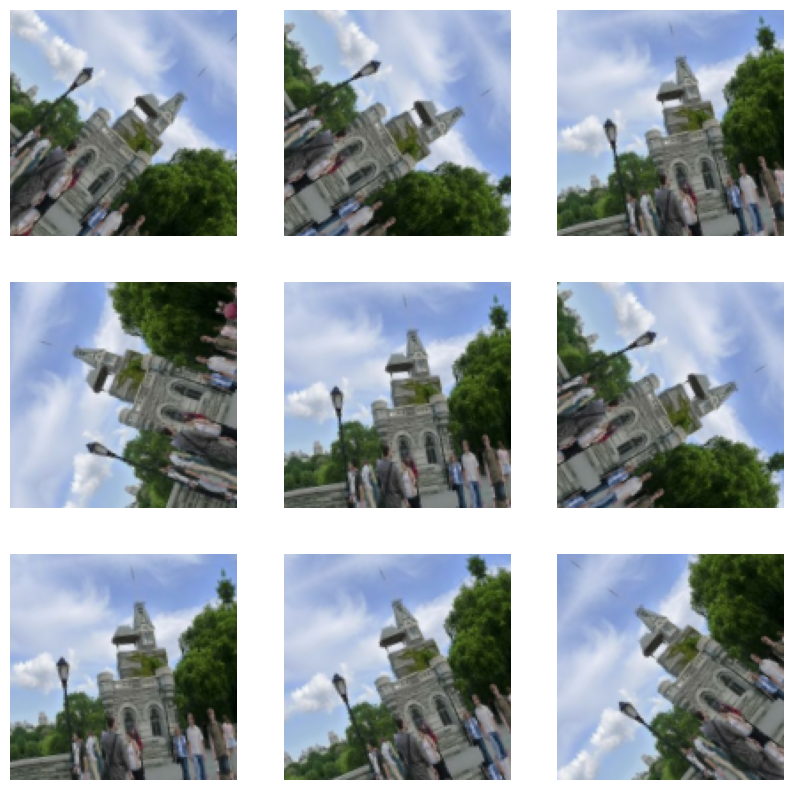

In [ ]:
from tensorflow.keras import layers

IMG_SIZE = 128

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

image = resize_and_rescale(image)

data_augmentation = tf.keras.Sequential([
  layers.RandomRotation(0.2)
])

# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [ ]:
aug_ds = train_ds.map(
  lambda x, y, _: (resize_and_rescale(x, training=True), y))

batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y, _: (resize_and_rescale(x), y),
              num_parallel_calls=AUTOTUNE)

  #if shuffle:
  #  ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  #if augment:
  #  ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
  #              num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

## Create Model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.applications.resnet50 import ResNet50
from keras.layers import Input

# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (128, 128)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

model = tf.keras.Sequential([
 layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(10, activation='softmax')
])

(32, 4, 4, 1280)


In [ ]:
base_model.trainable = False
# Let's take a look at the base model architecture
base_model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_10[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

epochs=3
#history = model.fit(
#  train_ds,
#  validation_data=val_ds,
#  epochs=epochs
#)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 sequential_24 (Sequential)  (None, 128, 128, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 128, 128, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 128, 128, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                           

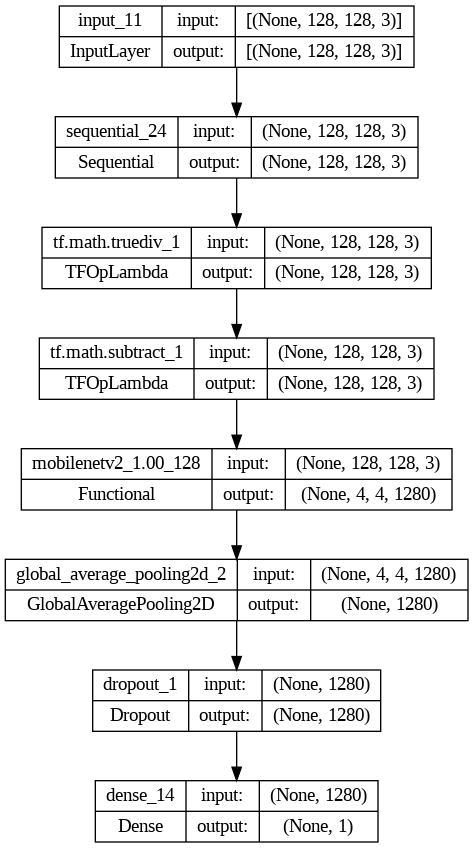

In [ ]:
len(model.trainable_variables)
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

3616/3616 [==============================] - 837s 231ms/step - loss: 0.9950 - accuracy: 0.0167
initial loss: 0.99
initial accuracy: 0.02


In [ ]:
history = model.fit(train_ds,
                    epochs=3,
                    validation_data=val_ds)

Epoch 1/3
3616/3616 [==============================] - 1717s 471ms/step - loss: -5859.5903 - accuracy: 2.5927e-05 - val_loss: -11719.9590 - val_accuracy: 0.0000e+00
Epoch 2/3
3616/3616 [==============================] - 1630s 450ms/step - loss: -17599.0762 - accuracy: 0.0000e+00 - val_loss: -23449.0801 - val_accuracy: 0.0000e+00
Epoch 3/3
3616/3616 [==============================] - 1642s 454ms/step - loss: -29326.9277 - accuracy: 0.0000e+00 - val_loss: -35178.0898 - val_accuracy: 0.0000e+00
